In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)
matplotlib 2.2.2
numpy 1.19.2
pandas 0.23.0
sklearn 0.23.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
import pprint

pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [7]:
# RandomizedSearchCV
# 1、转化为sklearn的model
# 2、定义参数集合
# 3、搜索参数

def build_model(hidden_layers = 1, 
                layer_size = 30, 
                learning_rate = 3e-3):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation="relu", input_shape=x_train.shape[1:]))
    
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size, activation="relu"))
        
        
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = "mse", optimizer = optimizer)
    
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(build_fn = build_model)

callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]

history = sklearn_model.fit(x_train_scaled, 
                            y_train, 
                            epochs = 100, 
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)
    

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 62us/sample - loss: 1.4062 - val_loss: 0.6998
Epoch 2/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.6145 - val_loss: 0.6286
Epoch 3/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5526 - val_loss: 0.5740
Epoch 4/100
11610/11610 [==============================] - 0s 35us/sample - loss: 0.5194 - val_loss: 0.5441
Epoch 5/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.4928 - val_loss: 0.5189
Epoch 6/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4761 - val_loss: 0.4990
Epoch 7/100
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4632 - val_loss: 0.4841
Epoch 8/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4530 - val_loss: 0.4777
Epoch 9/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.444

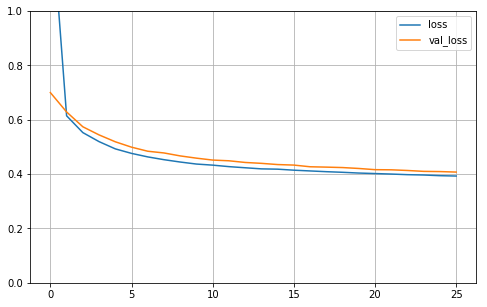

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

随机搜索RandomizedSearchCV原理

In [9]:
from  scipy.stats import reciprocal
# f(x) = 1/(x * log(b/a))  a<= x <= b

# 定义参数分布
param_distribution = {
    "hidden_layers":[1, 2,3,4],
    "layer_size": np.arange(1, 100), 
    "learning_rate": reciprocal(1e-4, 1e-2),
}


from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model, 
                  param_distribution,
                  n_iter = 10,
                  n_jobs = 1)


random_search_cv.fit(x_train_scaled, y_train, epochs=100,
                    validation_data = (x_valid_scaled, y_valid),
                    callbacks = callbacks)


# cross_validation: 训练集分成n份，n-1训练，最后一份验证.

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 78us/sample - loss: 1.2458 - val_loss: 0.7299
Epoch 2/100
9288/9288 [==============================] - 0s 43us/sample - loss: 0.6482 - val_loss: 0.6412
Epoch 3/100
9288/9288 [==============================] - 0s 43us/sample - loss: 0.5609 - val_loss: 0.5728
Epoch 4/100
9288/9288 [==============================] - 0s 41us/sample - loss: 0.5158 - val_loss: 0.5243
Epoch 5/100
9288/9288 [==============================] - 0s 41us/sample - loss: 0.4851 - val_loss: 0.5027
Epoch 6/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4595 - val_loss: 0.4718
Epoch 7/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4443 - val_loss: 0.4595
Epoch 8/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4289 - val_loss: 0.4412
Epoch 9/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4182 - val_loss: 0.435

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 77us/sample - loss: 1.1235 - val_loss: 0.7852
Epoch 2/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.6474 - val_loss: 0.6468
Epoch 3/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5731 - val_loss: 0.5943
Epoch 4/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5324 - val_loss: 0.5623
Epoch 5/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5035 - val_loss: 0.5336
Epoch 6/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4753 - val_loss: 0.5039
Epoch 7/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.4601 - val_loss: 0.4818
Epoch 8/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4455 - val_loss: 0.4795
Epoch 9/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.4387 - val_loss: 0.458

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 77us/sample - loss: 1.3576 - val_loss: 0.7176
Epoch 2/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.6242 - val_loss: 0.6372
Epoch 3/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5610 - val_loss: 0.5801
Epoch 4/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5193 - val_loss: 0.5383
Epoch 5/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.4896 - val_loss: 0.5198
Epoch 6/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4674 - val_loss: 0.4887
Epoch 7/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4517 - val_loss: 0.4700
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4379 - val_loss: 0.4562
Epoch 9/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4274 - val_loss: 0.445

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 86us/sample - loss: 1.1771 - val_loss: 0.7151
Epoch 2/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.7433 - val_loss: 0.6302
Epoch 3/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5958 - val_loss: 0.5535
Epoch 4/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4858 - val_loss: 0.5144
Epoch 5/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4626 - val_loss: 0.4935
Epoch 6/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4461 - val_loss: 0.4773
Epoch 7/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4337 - val_loss: 0.4614
Epoch 8/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.4227 - val_loss: 0.4491
Epoch 9/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.4149 - val_loss: 0.448

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 74us/sample - loss: 1.2472 - val_loss: 0.7183
Epoch 2/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.6143 - val_loss: 0.6073
Epoch 3/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5313 - val_loss: 0.5533
Epoch 4/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4901 - val_loss: 0.5159
Epoch 5/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.4704 - val_loss: 0.4887
Epoch 6/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4485 - val_loss: 0.4694
Epoch 7/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4350 - val_loss: 0.4614
Epoch 8/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4240 - val_loss: 0.4477
Epoch 9/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4159 - val_loss: 0.445

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 79us/sample - loss: 1.4844 - val_loss: 0.8655
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7291 - val_loss: 0.7043
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.6630 - val_loss: 0.6551
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5907 - val_loss: 0.6042
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5614 - val_loss: 0.5902
Epoch 6/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5318 - val_loss: 0.5579
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5169 - val_loss: 0.5432
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5040 - val_loss: 0.5320
Epoch 9/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4976 - val_loss: 0.518

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 68us/sample - loss: 1.4270 - val_loss: 0.8157
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7012 - val_loss: 0.7020
Epoch 3/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.6328 - val_loss: 0.6395
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5815 - val_loss: 0.5982
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5437 - val_loss: 0.5636
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5054 - val_loss: 0.5350
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4849 - val_loss: 0.5261
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4745 - val_loss: 0.5006
Epoch 9/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4669 - val_loss: 0.493

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 68us/sample - loss: 1.5820 - val_loss: 0.7567
Epoch 2/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.6567 - val_loss: 0.6722
Epoch 3/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5877 - val_loss: 0.6132
Epoch 4/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5459 - val_loss: 0.5749
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5158 - val_loss: 0.5455
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4972 - val_loss: 0.5263
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4808 - val_loss: 0.5087
Epoch 8/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.4709 - val_loss: 0.4938
Epoch 9/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4610 - val_loss: 0.483

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 81us/sample - loss: 1.4565 - val_loss: 0.7740
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.6438 - val_loss: 0.6451
Epoch 3/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5932 - val_loss: 0.6146
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5467 - val_loss: 0.5749
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5661 - val_loss: 0.5674
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5259 - val_loss: 0.5367
Epoch 7/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5055 - val_loss: 0.5208
Epoch 8/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4773 - val_loss: 0.5012
Epoch 9/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4681 - val_loss: 0.496

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 68us/sample - loss: 1.2497 - val_loss: 0.7714
Epoch 2/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.6472 - val_loss: 0.6747
Epoch 3/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5889 - val_loss: 0.6220
Epoch 4/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5454 - val_loss: 0.5825
Epoch 5/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5321 - val_loss: 0.5634
Epoch 6/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5157 - val_loss: 0.5426
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5130 - val_loss: 0.5325
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5079 - val_loss: 0.5039
Epoch 9/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4639 - val_loss: 0.496

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 68us/sample - loss: 3.2359 - val_loss: 2.4588
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 1.8954 - val_loss: 1.6349
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 1.3414 - val_loss: 1.2664
Epoch 4/100
9288/9288 [==============================] - 0s 36us/sample - loss: 1.0825 - val_loss: 1.0834
Epoch 5/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.9460 - val_loss: 0.9815
Epoch 6/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.8673 - val_loss: 0.9187
Epoch 7/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.8189 - val_loss: 0.8785
Epoch 8/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.7867 - val_loss: 0.8497
Epoch 9/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.7642 - val_loss: 0.828

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 81us/sample - loss: 3.6177 - val_loss: 2.2954
Epoch 2/100
9288/9288 [==============================] - 0s 36us/sample - loss: 1.6439 - val_loss: 1.3301
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 1.0983 - val_loss: 1.0440
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.9179 - val_loss: 0.9356
Epoch 5/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.8420 - val_loss: 0.8849
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.8040 - val_loss: 0.8549
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7807 - val_loss: 0.8338
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7643 - val_loss: 0.8176
Epoch 9/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7511 - val_loss: 0.803

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 69us/sample - loss: 4.3261 - val_loss: 3.1675
Epoch 2/100
9288/9288 [==============================] - 0s 38us/sample - loss: 2.3121 - val_loss: 1.8961
Epoch 3/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.5251 - val_loss: 1.3649
Epoch 4/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.1611 - val_loss: 1.1112
Epoch 5/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.9734 - val_loss: 0.9778
Epoch 6/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.8695 - val_loss: 0.9029
Epoch 7/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.8104 - val_loss: 0.8587
Epoch 8/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.7746 - val_loss: 0.8317
Epoch 9/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.7515 - val_loss: 0.812

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 69us/sample - loss: 3.1856 - val_loss: 2.4796
Epoch 2/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.8882 - val_loss: 1.6691
Epoch 3/100
9288/9288 [==============================] - 0s 35us/sample - loss: 1.3370 - val_loss: 1.2957
Epoch 4/100
9288/9288 [==============================] - 0s 34us/sample - loss: 1.0790 - val_loss: 1.0976
Epoch 5/100
9288/9288 [==============================] - 0s 34us/sample - loss: 0.9421 - val_loss: 0.9787
Epoch 6/100
9288/9288 [==============================] - 0s 34us/sample - loss: 0.8601 - val_loss: 0.9031
Epoch 7/100
9288/9288 [==============================] - 0s 34us/sample - loss: 0.8066 - val_loss: 0.8534
Epoch 8/100
9288/9288 [==============================] - 0s 34us/sample - loss: 0.7700 - val_loss: 0.8194
Epoch 9/100
9288/9288 [==============================] - 0s 34us/sample - loss: 0.7435 - val_loss: 0.795

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 84us/sample - loss: 4.1524 - val_loss: 2.9660
Epoch 2/100
9288/9288 [==============================] - 0s 36us/sample - loss: 2.1989 - val_loss: 1.7895
Epoch 3/100
9288/9288 [==============================] - 0s 36us/sample - loss: 1.4546 - val_loss: 1.2915
Epoch 4/100
9288/9288 [==============================] - 0s 36us/sample - loss: 1.1141 - val_loss: 1.0633
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.9448 - val_loss: 0.9504
Epoch 6/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.8557 - val_loss: 0.8894
Epoch 7/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.8047 - val_loss: 0.8529
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7725 - val_loss: 0.8273
Epoch 9/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.7496 - val_loss: 0.809

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 69us/sample - loss: 1.2658 - val_loss: 0.7057
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.6256 - val_loss: 0.6213
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5642 - val_loss: 0.5674
Epoch 4/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.5223 - val_loss: 0.5250
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4932 - val_loss: 0.5177
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4767 - val_loss: 0.4914
Epoch 7/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4655 - val_loss: 0.4685
Epoch 8/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4564 - val_loss: 0.4640
Epoch 9/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4483 - val_loss: 0.454

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 68us/sample - loss: 1.2095 - val_loss: 0.6086
Epoch 2/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5434 - val_loss: 0.5390
Epoch 3/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4957 - val_loss: 0.5054
Epoch 4/100
9288/9288 [==============================] - 0s 35us/sample - loss: 0.4723 - val_loss: 0.4896
Epoch 5/100
9288/9288 [==============================] - 0s 35us/sample - loss: 0.4696 - val_loss: 0.4917
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4741 - val_loss: 0.4832
Epoch 7/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4719 - val_loss: 0.5043
Epoch 8/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4512 - val_loss: 0.4741
Epoch 9/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4493 - val_loss: 0.464

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 68us/sample - loss: 1.6183 - val_loss: 0.7589
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.6527 - val_loss: 0.6345
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5608 - val_loss: 0.5761
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5269 - val_loss: 0.5454
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5042 - val_loss: 0.5249
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4852 - val_loss: 0.5122
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4771 - val_loss: 0.4972
Epoch 8/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4683 - val_loss: 0.4912
Epoch 9/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4599 - val_loss: 0.481

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 84us/sample - loss: 1.4099 - val_loss: 0.7357
Epoch 2/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.6145 - val_loss: 0.6540
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5608 - val_loss: 0.5998
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5205 - val_loss: 0.5597
Epoch 5/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4896 - val_loss: 0.5218
Epoch 6/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4683 - val_loss: 0.4991
Epoch 7/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4539 - val_loss: 0.4838
Epoch 8/100
9288/9288 [==============================] - 0s 35us/sample - loss: 0.4435 - val_loss: 0.4740
Epoch 9/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4373 - val_loss: 0.466

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 67us/sample - loss: 1.5188 - val_loss: 0.6980
Epoch 2/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.6007 - val_loss: 0.6160
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5471 - val_loss: 0.5779
Epoch 4/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.5184 - val_loss: 0.5662
Epoch 5/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4980 - val_loss: 0.5275
Epoch 6/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4828 - val_loss: 0.5073
Epoch 7/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4723 - val_loss: 0.4950
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4592 - val_loss: 0.4943
Epoch 9/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4489 - val_loss: 0.479

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 68us/sample - loss: 1.2066 - val_loss: 0.7475
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7521 - val_loss: 0.6189
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5521 - val_loss: 0.5572
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5099 - val_loss: 0.5251
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4872 - val_loss: 0.5014
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4714 - val_loss: 0.4877
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4588 - val_loss: 0.4733
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4498 - val_loss: 0.4616
Epoch 9/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4400 - val_loss: 0.450

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 87us/sample - loss: 1.1184 - val_loss: 0.7632
Epoch 2/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.6576 - val_loss: 0.6569
Epoch 3/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5670 - val_loss: 0.5717
Epoch 4/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5414 - val_loss: 0.5883
Epoch 5/100
9288/9288 [==============================] - 0s 35us/sample - loss: 0.5254 - val_loss: 0.5394
Epoch 6/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.5684 - val_loss: 0.5096
Epoch 7/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.5255 - val_loss: 0.4743
Epoch 8/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4443 - val_loss: 0.4630
Epoch 9/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4302 - val_loss: 0.457

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 67us/sample - loss: 1.1653 - val_loss: 0.7319
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5828 - val_loss: 0.5536
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5113 - val_loss: 0.5254
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4843 - val_loss: 0.5014
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4683 - val_loss: 0.5001
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4514 - val_loss: 0.4757
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4431 - val_loss: 0.4670
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4369 - val_loss: 0.4572
Epoch 9/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4422 - val_loss: 0.456

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 68us/sample - loss: 1.1231 - val_loss: 0.7459
Epoch 2/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.7849 - val_loss: 0.6872
Epoch 3/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.6407 - val_loss: 0.5671
Epoch 4/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.5136 - val_loss: 0.5409
Epoch 5/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4864 - val_loss: 0.5266
Epoch 6/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4706 - val_loss: 0.5025
Epoch 7/100
9288/9288 [==============================] - 0s 35us/sample - loss: 0.4577 - val_loss: 0.4890
Epoch 8/100
9288/9288 [==============================] - 0s 35us/sample - loss: 0.4481 - val_loss: 0.4808
Epoch 9/100
9288/9288 [==============================] - 0s 35us/sample - loss: 0.4400 - val_loss: 0.471

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 70us/sample - loss: 1.1065 - val_loss: 0.8451
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.9008 - val_loss: 0.6538
Epoch 3/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.5802 - val_loss: 0.5748
Epoch 4/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5074 - val_loss: 0.5352
Epoch 5/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.4816 - val_loss: 0.5047
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4603 - val_loss: 0.4852
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4476 - val_loss: 0.4741
Epoch 8/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4373 - val_loss: 0.4609
Epoch 9/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4282 - val_loss: 0.453

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 92us/sample - loss: 2.3845 - val_loss: 1.1037
Epoch 2/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.8885 - val_loss: 0.8106
Epoch 3/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.7294 - val_loss: 0.7420
Epoch 4/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.6784 - val_loss: 0.7051
Epoch 5/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.6471 - val_loss: 0.6785
Epoch 6/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.6221 - val_loss: 0.6549
Epoch 7/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.6005 - val_loss: 0.6308
Epoch 8/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5811 - val_loss: 0.6107
Epoch 9/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5639 - val_loss: 0.593

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 74us/sample - loss: 2.3154 - val_loss: 1.0127
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7752 - val_loss: 0.7244
Epoch 3/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.6452 - val_loss: 0.6722
Epoch 4/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.6067 - val_loss: 0.6380
Epoch 5/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5794 - val_loss: 0.6106
Epoch 6/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.5562 - val_loss: 0.5874
Epoch 7/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5367 - val_loss: 0.5683
Epoch 8/100
9288/9288 [==============================] - 0s 35us/sample - loss: 0.5193 - val_loss: 0.5499
Epoch 9/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5043 - val_loss: 0.537

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 75us/sample - loss: 2.2189 - val_loss: 1.0750
Epoch 2/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.8357 - val_loss: 0.7999
Epoch 3/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.7144 - val_loss: 0.7395
Epoch 4/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.6662 - val_loss: 0.6986
Epoch 5/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.6306 - val_loss: 0.6650
Epoch 6/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.6014 - val_loss: 0.6362
Epoch 7/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5764 - val_loss: 0.6113
Epoch 8/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5544 - val_loss: 0.5914
Epoch 9/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.5369 - val_loss: 0.570

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 76us/sample - loss: 2.2638 - val_loss: 1.2453
Epoch 2/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.8847 - val_loss: 0.8482
Epoch 3/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.6954 - val_loss: 0.7278
Epoch 4/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.6336 - val_loss: 0.6799
Epoch 5/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5988 - val_loss: 0.6432
Epoch 6/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5728 - val_loss: 0.6176
Epoch 7/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5521 - val_loss: 0.5989
Epoch 8/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5348 - val_loss: 0.5788
Epoch 9/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5204 - val_loss: 0.563

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 73us/sample - loss: 2.0518 - val_loss: 1.0574
Epoch 2/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.8596 - val_loss: 0.8353
Epoch 3/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.7308 - val_loss: 0.7714
Epoch 4/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.6818 - val_loss: 0.7296
Epoch 5/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.6469 - val_loss: 0.6976
Epoch 6/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.6176 - val_loss: 0.6671
Epoch 7/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5936 - val_loss: 0.6424
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5724 - val_loss: 0.6199
Epoch 9/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.5537 - val_loss: 0.600

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 82us/sample - loss: 0.9020 - val_loss: 0.6263
Epoch 2/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5223 - val_loss: 0.5153
Epoch 3/100
9288/9288 [==============================] - 0s 41us/sample - loss: 0.4540 - val_loss: 0.4627
Epoch 4/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4105 - val_loss: 0.4466
Epoch 5/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3972 - val_loss: 0.4016
Epoch 6/100
9288/9288 [==============================] - 0s 42us/sample - loss: 0.3777 - val_loss: 0.5508
Epoch 7/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3703 - val_loss: 0.3850
Epoch 8/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3647 - val_loss: 0.3885
Epoch 9/100
9288/9288 [==============================] - 0s 41us/sample - loss: 0.3576 - val_loss: 0.525

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 82us/sample - loss: 1.1389 - val_loss: 0.6009
Epoch 2/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.5247 - val_loss: 0.5230
Epoch 3/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4609 - val_loss: 0.4825
Epoch 4/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4260 - val_loss: 0.4361
Epoch 5/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3998 - val_loss: 0.4107
Epoch 6/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.3855 - val_loss: 0.6510
Epoch 7/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3737 - val_loss: 0.3897
Epoch 8/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3579 - val_loss: 0.3872
Epoch 9/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3525 - val_loss: 0.391

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 102us/sample - loss: 0.9285 - val_loss: 0.5821
Epoch 2/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4713 - val_loss: 0.4694
Epoch 3/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4105 - val_loss: 0.4276
Epoch 4/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3878 - val_loss: 0.3903
Epoch 5/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3716 - val_loss: 0.4143
Epoch 6/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3602 - val_loss: 0.3715
Epoch 7/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3508 - val_loss: 0.3773
Epoch 8/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3419 - val_loss: 0.3500
Epoch 9/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3347 - val_loss: 0.53

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 81us/sample - loss: 0.8253 - val_loss: 0.5740
Epoch 2/100
9288/9288 [==============================] - 0s 41us/sample - loss: 0.4941 - val_loss: 0.4905
Epoch 3/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4266 - val_loss: 0.4492
Epoch 4/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3976 - val_loss: 0.4679
Epoch 5/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4182 - val_loss: 0.4291
Epoch 6/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4215 - val_loss: 0.4544
Epoch 7/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3791 - val_loss: 0.3942
Epoch 8/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3851 - val_loss: 0.4128
Epoch 9/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3380 - val_loss: 0.355

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 81us/sample - loss: 0.7251 - val_loss: 0.5273
Epoch 2/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4891 - val_loss: 0.7278
Epoch 3/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.4689 - val_loss: 0.4369
Epoch 4/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3902 - val_loss: 0.4284
Epoch 5/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3746 - val_loss: 0.4296
Epoch 6/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3611 - val_loss: 0.4045
Epoch 7/100
9288/9288 [==============================] - 0s 41us/sample - loss: 0.3535 - val_loss: 0.3843
Epoch 8/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.3487 - val_loss: 0.3673
Epoch 9/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3420 - val_loss: 0.376

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 70us/sample - loss: 2.5004 - val_loss: 1.2014
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.9226 - val_loss: 0.8204
Epoch 3/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.7255 - val_loss: 0.7463
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.6759 - val_loss: 0.7118
Epoch 5/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.6473 - val_loss: 0.6829
Epoch 6/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.6235 - val_loss: 0.6585
Epoch 7/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.6033 - val_loss: 0.6374
Epoch 8/100
9288/9288 [==============================] - 0s 35us/sample - loss: 0.5854 - val_loss: 0.6175
Epoch 9/100
9288/9288 [==============================] - 0s 35us/sample - loss: 0.5693 - val_loss: 0.600

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 89us/sample - loss: 2.1556 - val_loss: 1.0391
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.8567 - val_loss: 0.8256
Epoch 3/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.7372 - val_loss: 0.7781
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7016 - val_loss: 0.7451
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.6751 - val_loss: 0.7184
Epoch 6/100
9288/9288 [==============================] - 0s 35us/sample - loss: 0.6515 - val_loss: 0.6947
Epoch 7/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.6307 - val_loss: 0.6732
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.6113 - val_loss: 0.6535
Epoch 9/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5949 - val_loss: 0.636

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 68us/sample - loss: 2.3584 - val_loss: 1.1508
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.9164 - val_loss: 0.8512
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7608 - val_loss: 0.7836
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7115 - val_loss: 0.7457
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.6796 - val_loss: 0.7177
Epoch 6/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.6547 - val_loss: 0.6940
Epoch 7/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.6332 - val_loss: 0.6723
Epoch 8/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.6140 - val_loss: 0.6534
Epoch 9/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5967 - val_loss: 0.635

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 69us/sample - loss: 2.7380 - val_loss: 1.1029
Epoch 2/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.8512 - val_loss: 0.7491
Epoch 3/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.6549 - val_loss: 0.7024
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.6189 - val_loss: 0.6797
Epoch 5/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.5970 - val_loss: 0.6589
Epoch 6/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5784 - val_loss: 0.6411
Epoch 7/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5630 - val_loss: 0.6240
Epoch 8/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.5497 - val_loss: 0.6085
Epoch 9/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.5379 - val_loss: 0.594

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 70us/sample - loss: 2.8816 - val_loss: 1.3773
Epoch 2/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.9608 - val_loss: 0.8462
Epoch 3/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.7191 - val_loss: 0.7554
Epoch 4/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.6722 - val_loss: 0.7226
Epoch 5/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.6462 - val_loss: 0.6935
Epoch 6/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.6263 - val_loss: 0.6721
Epoch 7/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.6088 - val_loss: 0.6579
Epoch 8/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.5929 - val_loss: 0.6389
Epoch 9/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.5804 - val_loss: 0.625

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 73us/sample - loss: 3.1698 - val_loss: 2.7157
Epoch 2/100
9288/9288 [==============================] - 0s 38us/sample - loss: 2.0788 - val_loss: 1.9179
Epoch 3/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.5199 - val_loss: 1.4918
Epoch 4/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.2334 - val_loss: 1.2525
Epoch 5/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.0712 - val_loss: 1.1020
Epoch 6/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.9672 - val_loss: 1.0000
Epoch 7/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.8950 - val_loss: 0.9289
Epoch 8/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.8433 - val_loss: 0.8784
Epoch 9/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.8050 - val_loss: 0.841

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 98us/sample - loss: 3.0416 - val_loss: 2.1958
Epoch 2/100
9288/9288 [==============================] - 0s 40us/sample - loss: 1.7185 - val_loss: 1.3524
Epoch 3/100
9288/9288 [==============================] - 0s 41us/sample - loss: 1.1849 - val_loss: 1.0328
Epoch 4/100
9288/9288 [==============================] - 0s 40us/sample - loss: 0.9642 - val_loss: 0.9114
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.8524 - val_loss: 0.8476
Epoch 6/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.7874 - val_loss: 0.8092
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7457 - val_loss: 0.7834
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.7180 - val_loss: 0.7645
Epoch 9/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.6973 - val_loss: 0.749

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 75us/sample - loss: 4.1996 - val_loss: 3.4121
Epoch 2/100
9288/9288 [==============================] - 0s 38us/sample - loss: 2.6630 - val_loss: 2.3256
Epoch 3/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.8990 - val_loss: 1.7477
Epoch 4/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.4747 - val_loss: 1.3995
Epoch 5/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.2064 - val_loss: 1.1663
Epoch 6/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.0252 - val_loss: 1.0106
Epoch 7/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.9034 - val_loss: 0.9054
Epoch 8/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.8212 - val_loss: 0.8350
Epoch 9/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.7665 - val_loss: 0.788

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 74us/sample - loss: 3.4171 - val_loss: 2.7344
Epoch 2/100
9288/9288 [==============================] - 0s 39us/sample - loss: 2.3821 - val_loss: 1.9343
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 1.7466 - val_loss: 1.4924
Epoch 4/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.3994 - val_loss: 1.2523
Epoch 5/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.1833 - val_loss: 1.1084
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 1.0392 - val_loss: 1.0036
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.9361 - val_loss: 0.9271
Epoch 8/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.8634 - val_loss: 0.8706
Epoch 9/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.8099 - val_loss: 0.826

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 75us/sample - loss: 3.0777 - val_loss: 2.4176
Epoch 2/100
9288/9288 [==============================] - 0s 39us/sample - loss: 1.9707 - val_loss: 1.6651
Epoch 3/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.4589 - val_loss: 1.3122
Epoch 4/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.1870 - val_loss: 1.1325
Epoch 5/100
9288/9288 [==============================] - 0s 38us/sample - loss: 1.0361 - val_loss: 1.0273
Epoch 6/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.9422 - val_loss: 0.9598
Epoch 7/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.8787 - val_loss: 0.9132
Epoch 8/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.8338 - val_loss: 0.8795
Epoch 9/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.8009 - val_loss: 0.853

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 70us/sample - loss: 0.9146 - val_loss: 0.6451
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.6844 - val_loss: 0.8215
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 1.0125 - val_loss: 0.5126
Epoch 4/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.4680 - val_loss: 0.4646
Epoch 5/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4441 - val_loss: 0.4459
Epoch 6/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4248 - val_loss: 0.4360
Epoch 7/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4128 - val_loss: 0.4296
Epoch 8/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.4023 - val_loss: 0.4112
Epoch 9/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3966 - val_loss: 0.411

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 92us/sample - loss: 1.8919 - val_loss: 1.6911
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 1.2774 - val_loss: 0.5204
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4319 - val_loss: 0.4342
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.3915 - val_loss: 0.4190
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.3757 - val_loss: 0.3849
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.3637 - val_loss: 0.3837
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.3588 - val_loss: 0.4193
Epoch 8/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.3623 - val_loss: 0.3642
Epoch 9/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3636 - val_loss: 0.362

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 68us/sample - loss: 1.6814 - val_loss: 0.7389
Epoch 2/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.6557 - val_loss: 0.5215
Epoch 3/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4665 - val_loss: 0.4822
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4372 - val_loss: 0.4554
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4195 - val_loss: 0.4443
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4161 - val_loss: 0.4296
Epoch 7/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.4002 - val_loss: 0.4235
Epoch 8/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3918 - val_loss: 0.4117
Epoch 9/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3865 - val_loss: 0.403

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 69us/sample - loss: 0.8822 - val_loss: 1.1529
Epoch 2/100
9288/9288 [==============================] - 0s 36us/sample - loss: 1.7516 - val_loss: 1.8417
Epoch 3/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4890 - val_loss: 0.4542
Epoch 4/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4001 - val_loss: 0.4102
Epoch 5/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.3825 - val_loss: 0.3860
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.3751 - val_loss: 0.3817
Epoch 7/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.3706 - val_loss: 0.3750
Epoch 8/100
9288/9288 [==============================] - 0s 39us/sample - loss: 0.3648 - val_loss: 0.3819
Epoch 9/100
9288/9288 [==============================] - 0s 41us/sample - loss: 0.3621 - val_loss: 0.370

Train on 9288 samples, validate on 3870 samples
Epoch 1/100
9288/9288 [==============================] - 1s 68us/sample - loss: 1.6412 - val_loss: 0.5810
Epoch 2/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.4871 - val_loss: 0.4670
Epoch 3/100
9288/9288 [==============================] - 0s 36us/sample - loss: 0.4186 - val_loss: 0.4303
Epoch 4/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.3953 - val_loss: 0.4076
Epoch 5/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.3842 - val_loss: 0.4082
Epoch 6/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.3777 - val_loss: 0.3935
Epoch 7/100
9288/9288 [==============================] - 0s 37us/sample - loss: 0.3728 - val_loss: 0.3945
Epoch 8/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.3717 - val_loss: 0.3846
Epoch 9/100
9288/9288 [==============================] - 0s 38us/sample - loss: 0.3702 - val_loss: 0.384

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x0000000020E2A2E8>, as the constructor either does not set or modifies parameter layer_size

In [10]:
print(random_search_cv.best_params_)# 输出最好的参数
print(random_search_cv.best_score_)# 输出最好的得分值
print(random_search_cv.best_estimator_)

{'hidden_layers': 4, 'layer_size': 36, 'learning_rate': 0.009778772934719848}
-0.362495801864155


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [11]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [ ]:
from  scipy.stats import reciprocal

reciprocal.rvs(1e-4, 1e-2, size = 10)